# Habitable Exoplanets -- Research Project 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import habitable_zone_plot as hzp
import random as rng
from collections import Counter

### Trim dataset to only necessary or useful parts

In [6]:
all_exoplanets = pd.read_csv('kepler.csv')
all_exoplanets_drop = all_exoplanets.drop(columns=['angular_distance','orbital_period','eccentricity','inclination','star_distance','star_age','star_metallicity','planet_status','mass','mass_error_min', 'mass_error_max','mass_sini', 'mass_sini_error_min', 'mass_sini_error_max','radius_error_min', 'radius_error_max', 'orbital_period_error_min', 'orbital_period_error_max','semi_major_axis_error_min','semi_major_axis_error_max','eccentricity_error_min','eccentricity_error_max','inclination_error_min','inclination_error_max','omega', 'omega_error_min', 'omega_error_max', 'tperi','tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min','tconj_error_max', 'tzero_tr', 'tzero_tr_error_min','tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min','tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min','lambda_angle_error_max', 'impact_parameter','impact_parameter_error_min', 'impact_parameter_error_max', 'tzero_vr','tzero_vr_error_min', 'tzero_vr_error_max', 'k', 'k_error_min','k_error_max','temp_calculated_error_min','temp_calculated_error_max','hot_point_lon','geometric_albedo', 'geometric_albedo_error_min','geometric_albedo_error_max', 'log_g', 'publication_status','detection_type', 'mass_detection_type', 'radius_detection_type','alternate_names', 'molecules', 'ra', 'dec','mag_v','mag_i', 'mag_j', 'mag_h', 'mag_k','star_distance_error_min', 'star_distance_error_max','star_metallicity_error_min','star_metallicity_error_max','star_mass_error_min','star_mass_error_max','star_radius_error_min','star_radius_error_max','star_age_error_min', 'star_age_error_max', 'star_teff','star_teff_error_min', 'star_teff_error_max', 'star_detected_disc','star_alternate_names', 'temp_calculated', 'temp_measured', 'star_magnetic_field', 'radius', 'discovered', 'updated'])

#drop rows with missing data & reset the index
exoplanets = all_exoplanets_drop.dropna()
exoplanets = exoplanets.reset_index(drop=True)
exoplanets = exoplanets.rename(columns={'star_sp_type':'spectral_type', '# name': 'planet_name'})

In [9]:
some_sp_types = all_exoplanets_drop['star_sp_type'].dropna()
some_sp_types = list(some_sp_types)

all_spectral_types = []
for entry in some_sp_types:
    if entry[0] != ' ':
        all_spectral_types.append(entry[0].upper())
    else:
        print(entry)
        all_spectral_types.append(entry[1].upper())
    
set_all_spectral_types = list(set(all_spectral_types))
set_all_spectral_types

 K0IIIb


['F', 'W', 'G', 'C', 'S', 'T', 'B', 'K', 'M', 'A', 'L', 'Y', 'P', 'D']

In [10]:
exoplanets

,planet_name,semi_major_axis,star_name,star_mass,star_radius,spectral_type
0,11 Com b,1.2900,11 Com,2.70,19.000,G8 III
1,11 UMi b,1.5400,11 UMi,1.80,24.080,K4III
2,14 And b,0.8300,14 And,2.20,11.000,K0III
3,14 Her b,2.7700,14 Her,0.90,0.708,K0 V
4,16 Cyg B b,1.6800,16 Cyg B,1.01,0.980,G2.5 V
...,...,...,...,...,...,...
869,tau Gem b,1.1700,tau Gem,2.30,26.800,K2III
870,ups And b,0.0590,ups And,1.27,1.631,F8 V
871,ups And c,0.8610,ups And,1.27,1.631,F8 V
872,ups And d,2.5500,ups And,1.27,1.631,F8 V


### Divide data into its various parts

In [11]:
planet_name = exoplanets['planet_name']
star_name = exoplanets['star_name']
semi_major_axis = exoplanets['semi_major_axis']
star_mass = exoplanets['star_mass']
star_radius = exoplanets['star_radius']
spectral_type = exoplanets['spectral_type']

In [12]:
class exoplanet(object):
    def __init__(self,pl_name,st_name,semi_major,st_mass,st_radius,st_spectral):
        
        self.pl_name = pl_name
        self.st_name = st_name
        self.semi_major = semi_major
        self.st_mass = st_mass
        self.st_radius = st_radius
        self.st_spectral = st_spectral
        self.st_temp = self.calculate_temp()
        self.st_lum = 4*np.pi*((st_radius*696342000)**2)*5.67e-8*(self.st_temp**4)
        self.habitable_zone = self.find_habitable_zone()
        self.habitability = self.find_habitability()
        
    def calculate_temp(self):
        if self.st_spectral[0] == 'O':
            return 40000
        elif self.st_spectral[0] == 'B':
            return 20000
        elif self.st_spectral[0] == 'A':
            return 8750
        elif self.st_spectral[0] == 'F':
            return 6750
        elif self.st_spectral[0] == 'G':
            return 5500
        elif self.st_spectral[0] == 'K':
            return 4250
        elif self.st_spectral[0] == 'M':
            return 3000
        elif self.st_spectral[0] == 's':
            return 30000
        else:
            return 3500
    
    def find_habitable_zone(self):
        scale = np.sqrt(self.st_lum / 3.828e26)
        
        inner = 0.95 * scale
        outer = 1.37 * scale
        
        return (inner,outer)
        
    def get_pl_name(self):
        return self.pl_name
    
    def get_st_name(self):
        return self.st_name
    
    def get_semi(self):
        return self.semi_major
    
    def get_st_mass(self):
        return self.st_mass
    
    def get_st_radius(self):
        return self.st_radius
    
    def get_st_spectral(self):
        return self.st_spectral
    
    def get_st_lum(self):
        return self.st_lum
    
    def get_st_temp(self):
        return self.st_temp
    
    def get_habitable_zone(self):
        return self.habitable_zone
    
    def find_habitability(self):
        if (self.habitable_zone[0] < self.semi_major) and (self.semi_major < self.habitable_zone[1]):
            return 1
        else:
            return 0
            

### Convert data into exoplanet objects

In [13]:
exoplanet_list = []

for row in exoplanets.iterrows():
    exoplanet_list.append(exoplanet(row[1][0],row[1][2],row[1][1],row[1][3],row[1][4],row[1][5]))
    
len(exoplanet_list)

874

In [14]:
habitable_zone_list=[]

for obj in exoplanet_list:
    habitable_zone_list.append(obj.get_habitable_zone())

In [15]:
semi_major_axis_list=[]

for obj in exoplanet_list:
    semi_major_axis_list.append(obj.get_semi())

In [16]:
habitability_list=[]

for obj in exoplanet_list:
    habitability_list.append(obj.find_habitability())

In [17]:
habitability_array=np.array(habitability_list)
habitable_number=int(len(np.where(habitability_array==1)[0]))
nonhabitable_number=int(len(np.where(habitability_array==0)[0]))
print(len(np.where(habitability_array==0)[0]), "is the number of uninhabitable exoplanets")
print(len(np.where(habitability_array==1)[0]), "is the number of habitable exoplanets")

823 is the number of uninhabitable exoplanets
51 is the number of habitable exoplanets


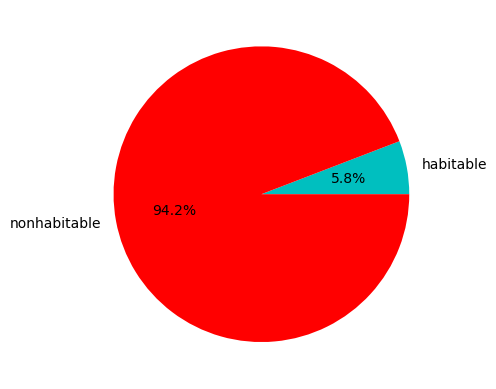

In [18]:
data=[habitable_number,nonhabitable_number]
types=["habitable","nonhabitable"]
color=["c","r"]
plt.pie(data,labels=types,autopct='%1.1f%%',colors=color);

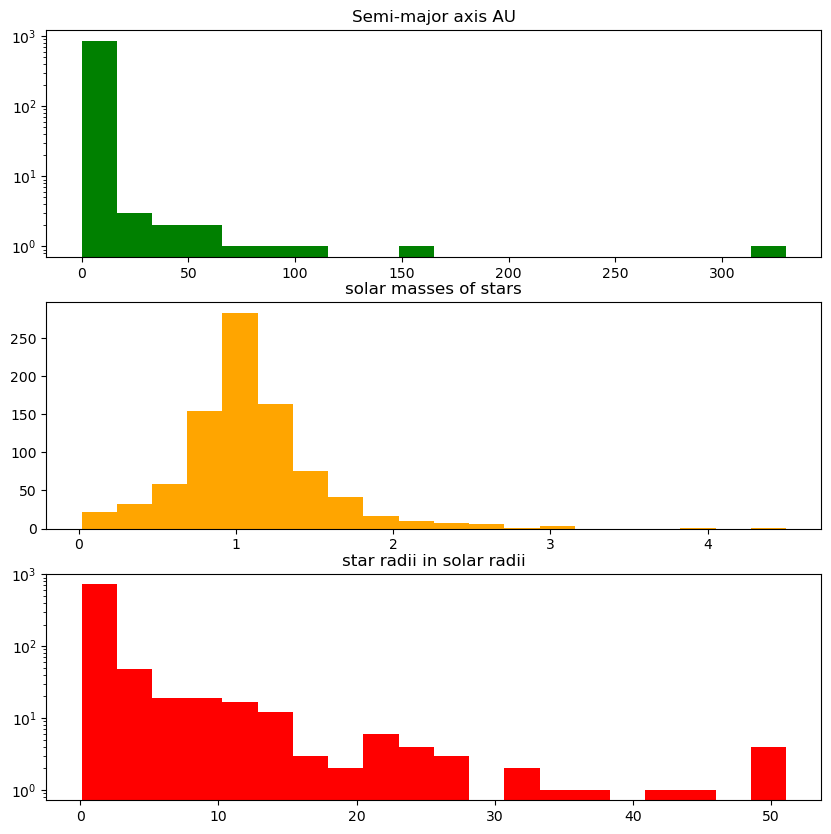

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.hist(semi_major_axis,20,color='green') 
plt.title("Semi-major axis AU")
plt.yscale('log')
plt.subplot(3,1,2)
plt.hist(star_mass,20,color='orange')
plt.title("solar masses of stars")
plt.subplot(3,1,3)
plt.hist(star_radius,20,color="red")
plt.title("star radii in solar radii")
plt.yscale('log');

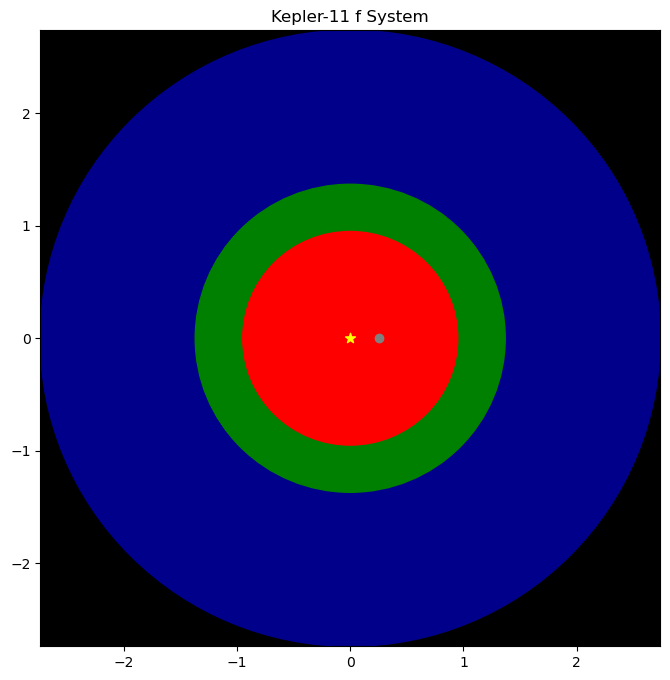

In [20]:
exo = rng.choice(exoplanet_list)

zone = exo.get_habitable_zone()
axis = exo.get_semi()
st_rad = exo.get_st_radius()
st_temp = exo.get_st_temp()
name = exo.get_pl_name()

fig, ax = hzp.plot_habitability(zone,axis,st_rad,st_temp,name);

In [37]:
some_sp_types = all_exoplanets_drop['star_sp_type'].dropna()
some_sp_types = list(some_sp_types)

all_spectral_types = []
for entry in some_sp_types:
    if entry[0] != ' ':
        all_spectral_types.append(entry[0].upper())
    else:
        print(entry)
        all_spectral_types.append(entry[1].upper())
    
set_all_spectral_types = list(set(all_spectral_types))
set_all_spectral_types

spec_type=[]
spec_type_habitability=[]
for obj in exoplanet_list:
    spec_type.append(obj.get_st_spectral()[0])
for i in range(len(spec_type)):
    if habitability_list[i]==1:
        spec_type_habitability.append(all_spectral_types[i])
    else:
        pass
spec_hab_numbers=Counter(spec_type_habitability)
spec_numbers=Counter(all_spectral_types)
spec_numbers

 K0IIIb


Counter({'G': 509,
         'M': 164,
         'K': 340,
         'S': 7,
         'L': 1,
         'F': 169,
         'T': 8,
         'A': 29,
         'D': 6,
         'B': 11,
         'C': 2,
         'W': 4,
         'P': 5,
         'Y': 1})

([<matplotlib.patches.Wedge at 0x7f2c36d83970>,
 [Text(0.3226027159710584, 1.0516308704332034, 'G'),
  Text(-1.0812108861223517, 0.20244263318411743, 'M'),
  Text(-0.5227778466626657, -0.9678343468996885, 'K'),
  Text(0.7719589846631627, -0.7836321369097997, 'F'),
  Text(1.0516308421167184, -0.3226028082780459, 'A'),
  Text(1.0917485142486596, -0.13448115717766787, 'Other'),
  Text(1.0999449437482718, -0.011005486023416604, 'W')],
 [Text(0.17596511780239546, 0.5736168384181108, '40.5%'),
  Text(-0.5897513924303736, 0.11042325446406404, '13.1%'),
  Text(-0.28515155272509035, -0.5279096437634664, '27.1%'),
  Text(0.4210685370889978, -0.4274357110417089, '13.5%'),
  Text(0.5736168229727555, -0.17596516815166136, '2.3%'),
  Text(0.5954991895901779, -0.07335335846054611, '3.3%'),
  Text(0.599969969317239, -0.006002992376409056, '0.3%')])

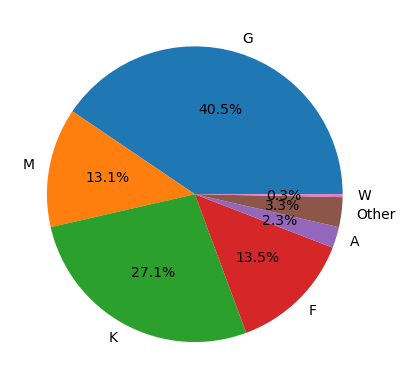

In [43]:
spec_num=[509,164,340,169,29,41,4]
spec_class=['G','M','K','F','A','Other','W']
plt.pie(spec_num,labels=spec_class,autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7f2c3ef99a30>,
 [Text(0.8569886275472014, 0.6896161919899824, 'K'),
  Text(-1.0812704308029282, 0.2021243564522854, 'G'),
  Text(0.30102951924317556, -1.0580081420028027, 'F'),
  Text(0.8978167608123014, -0.6355509924502573, 'M'),
  Text(1.0667766995203567, -0.2683048142699921, 'A'),
  Text(1.097913679690937, -0.06771670360780027, 'W')],
 [Text(0.46744834229847343, 0.37615428653999033, '21.6%'),
  Text(-0.5897838713470517, 0.11024964897397385, '51.0%'),
  Text(0.16419791958718663, -0.5770953501833469, '13.7%'),
  Text(0.48971823317034613, -0.3466641777001403, '7.8%'),
  Text(0.5818781997383763, -0.14634808051090475, '3.9%'),
  Text(0.5988620071041474, -0.03693638378607287, '2.0%')])

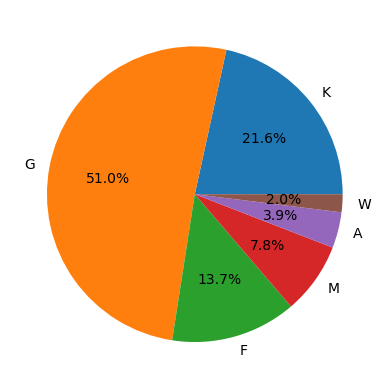

In [40]:
hab_num=[11,26,7,4,2,1]
hab_class=['K',"G",'F',"M","A","W"]
plt.pie(hab_num,labels=hab_class,autopct='%1.1f%%')